## Куриленко С.М. ДЗ №3 Группировка данных и оконные функции (vo_HW)

**Создание таблиц**



```
CREATE TABLE customer (
    customer_id INT PRIMARY KEY,
    first_name VARCHAR(50) NOT NULL,
    last_name VARCHAR(50) NOT NULL,
    gender CHAR(6),
    DOB DATE, -- Дата рождения
    job_title VARCHAR(100),
    job_industry_category VARCHAR(100),
    wealth_segment VARCHAR(50),
    deceased_indicator CHAR(1) DEFAULT 'N', -- Y или N
    owns_car CHAR(3),
    address VARCHAR(255),
    postcode VARCHAR(20),
    state VARCHAR(50),
    country VARCHAR(50),
    property_valuation INT
);
```



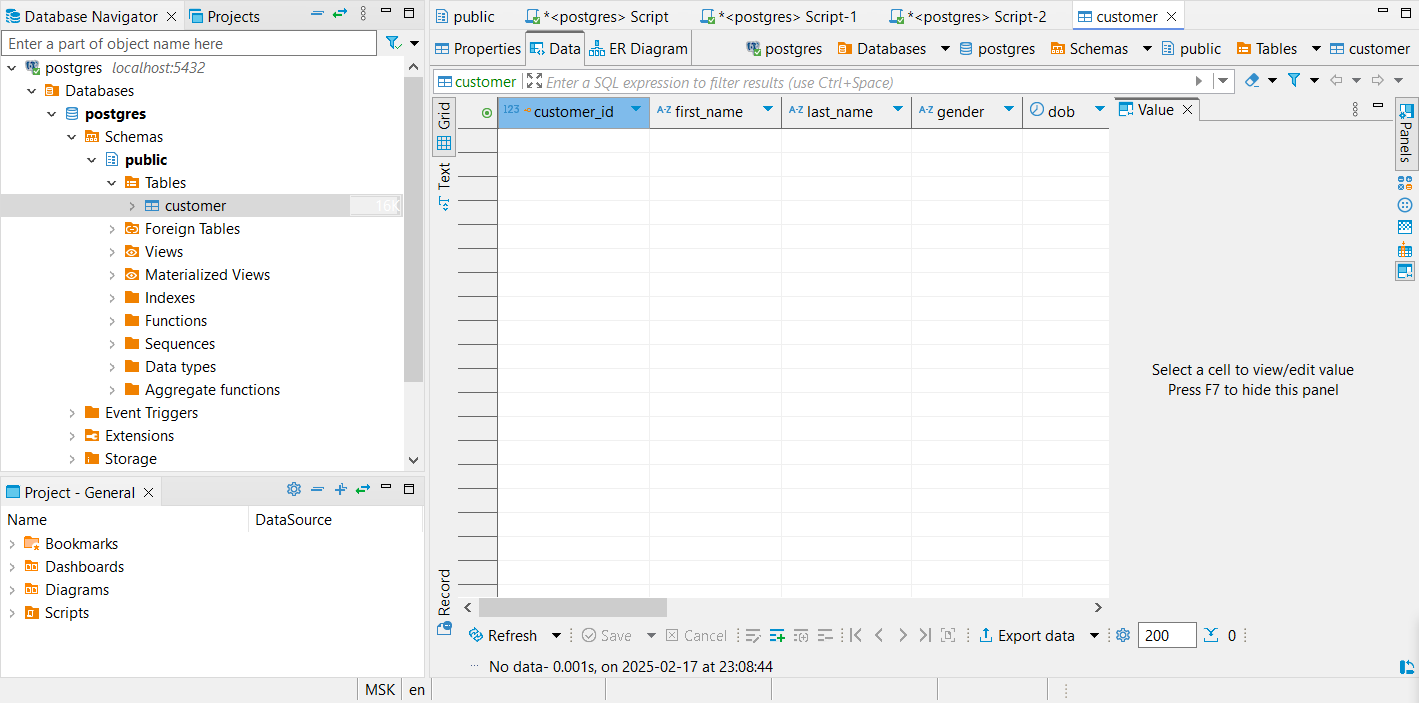



```
CREATE TABLE transaction (
    transaction_id INT PRIMARY KEY,
    product_id INT NOT NULL,
    customer_id INT NOT NULL,
    transaction_date DATE NOT NULL,
    online_order BOOLEAN,
    order_status VARCHAR(50), -- Например, "Completed", "Cancelled"
    brand VARCHAR(100),
    product_line VARCHAR(100),
    product_class VARCHAR(50),
    product_size VARCHAR(50),
    list_price DECIMAL(10, 2), -- Цена с двумя знаками после запятой
    standard_cost DECIMAL(10, 2), -- Стандартная стоимость с двумя знаками после запятой
    CONSTRAINT fk_customer
        FOREIGN KEY (customer_id)
        REFERENCES customer(customer_id)
        ON DELETE CASCADE
);
```



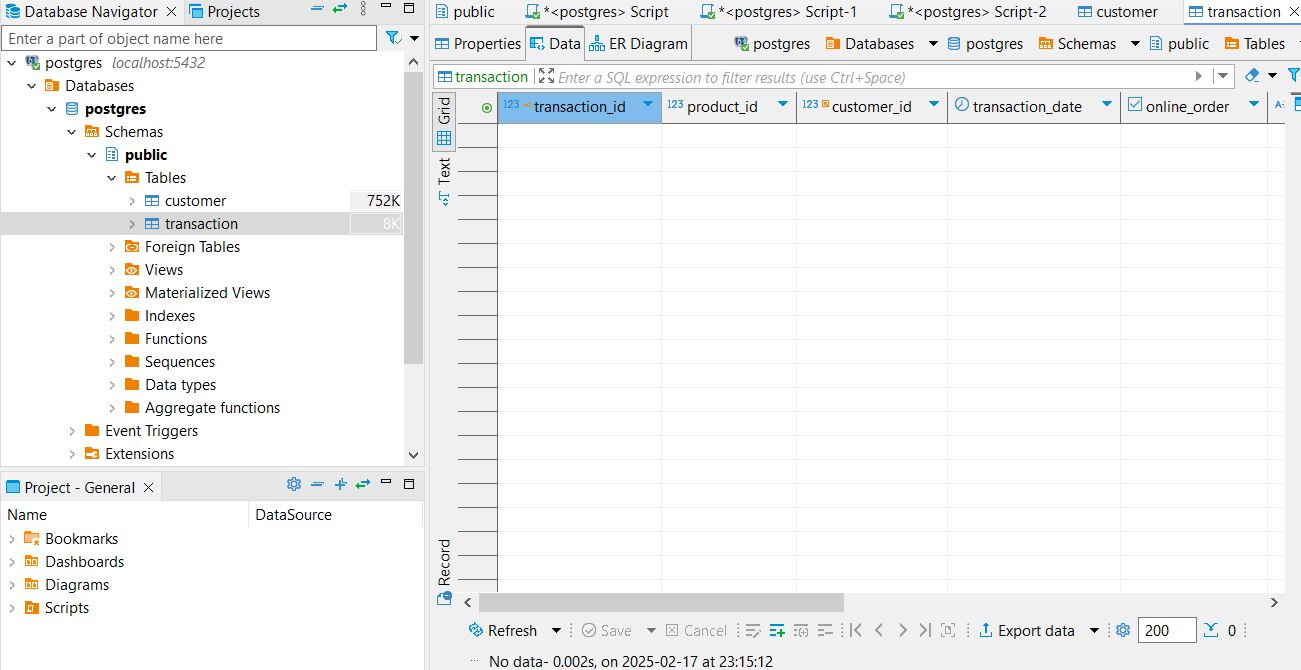

Загрузим данные через dbeawer

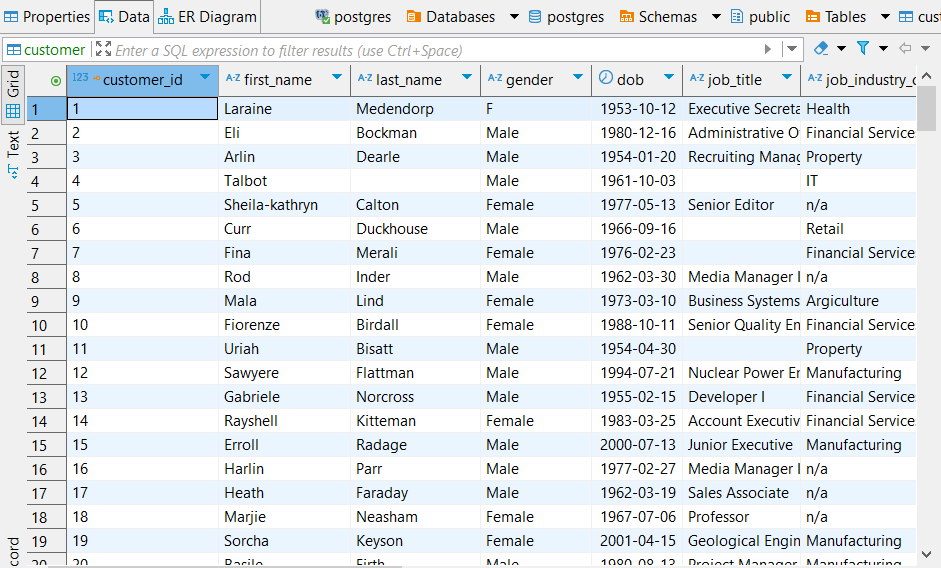

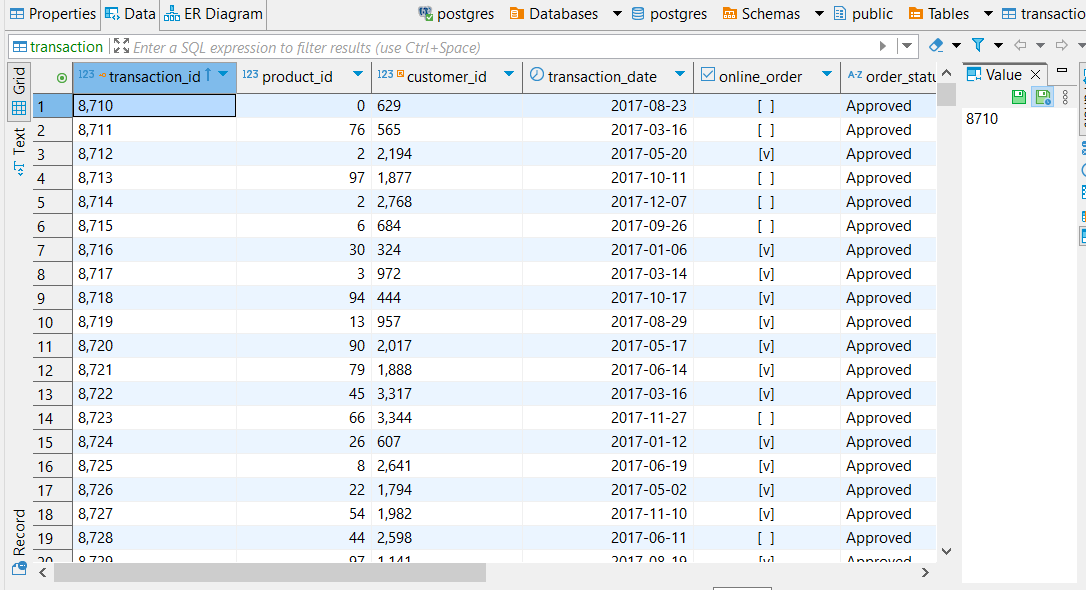



**1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.**



```
SELECT job_industry_category, COUNT(customer_id) AS client_count
FROM customer
GROUP BY job_industry_category
ORDER BY client_count DESC;
```



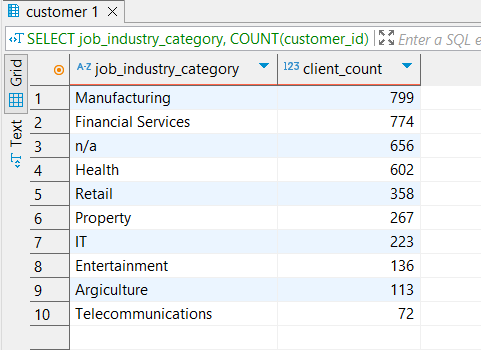

**2. Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности.**



```
SELECT
    TO_CHAR(t.transaction_date, 'YYYY-MM') AS month, -- Группировка по месяцам
    c.job_industry_category, -- Сфера деятельности
    SUM(t.list_price) AS total_transactions_sum -- Сумма транзакций
FROM transaction t
JOIN customer c ON t.customer_id = c.customer_id
GROUP BY TO_CHAR(t.transaction_date, 'YYYY-MM'), c.job_industry_category
ORDER BY TO_CHAR(t.transaction_date, 'YYYY-MM'), c.job_industry_category;
```



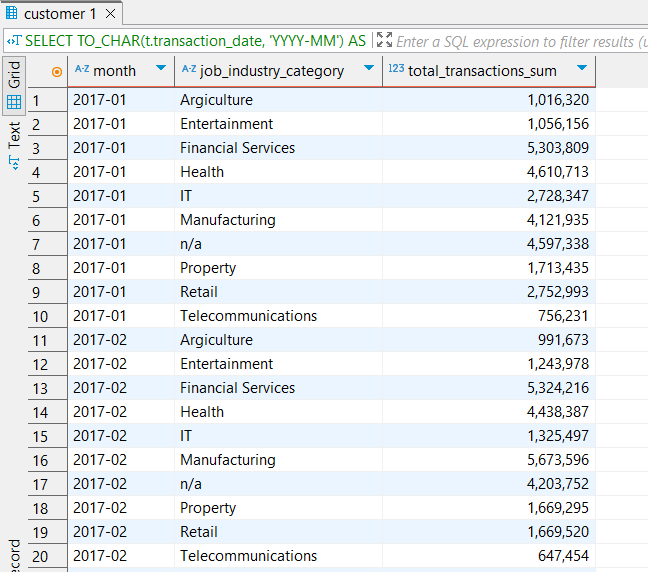

**3. Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.**



```
SELECT
    t.brand, -- Бренд
    COUNT(t.transaction_id) AS online_orders_count -- Количество онлайн-заказов
FROM transaction t
JOIN customer c ON t.customer_id = c.customer_id
WHERE c.job_industry_category = 'IT' -- Фильтр по сфере деятельности (IT)
  AND t.order_status = 'Approved' -- Фильтр по подтвержденным заказам
  AND t.online_order = 'Y' -- Фильтр по онлайн-заказам
GROUP BY t.brand
ORDER BY online_orders_count DESC;
```



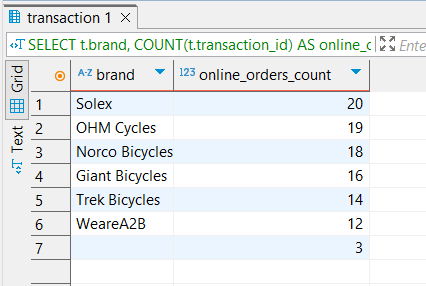

**4. Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества клиентов. Выполните двумя способами: используя только group by и используя только оконные функции. Сравните результат.**



```
SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(t.list_price) AS total_sum, -- Сумма всех транзакций
    MAX(t.list_price) AS max_price, -- Максимальная цена
    MIN(t.list_price) AS min_price, -- Минимальная цена
    COUNT(t.transaction_id) AS transaction_count -- Количество транзакций
FROM customer c
JOIN transaction t ON c.customer_id = t.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY total_sum DESC, transaction_count DESC;
```



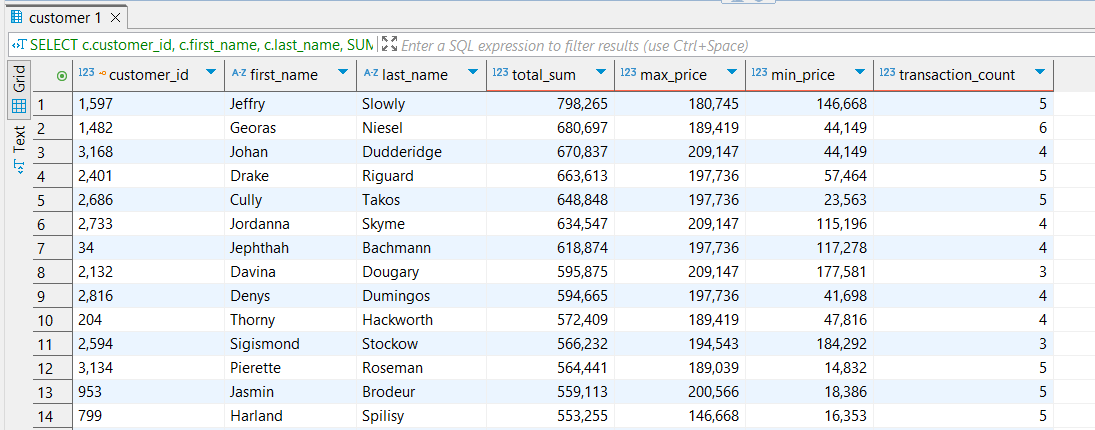



```
SELECT DISTINCT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(t.list_price) OVER (PARTITION BY c.customer_id) AS total_sum, -- Сумма всех транзакций
    MAX(t.list_price) OVER (PARTITION BY c.customer_id) AS max_price, -- Максимальная цена
    MIN(t.list_price) OVER (PARTITION BY c.customer_id) AS min_price, -- Минимальная цена
    COUNT(t.transaction_id) OVER (PARTITION BY c.customer_id) AS transaction_count -- Количество транзакций
FROM customer c
JOIN transaction t ON c.customer_id = t.customer_id
ORDER BY total_sum DESC, transaction_count DESC;
```



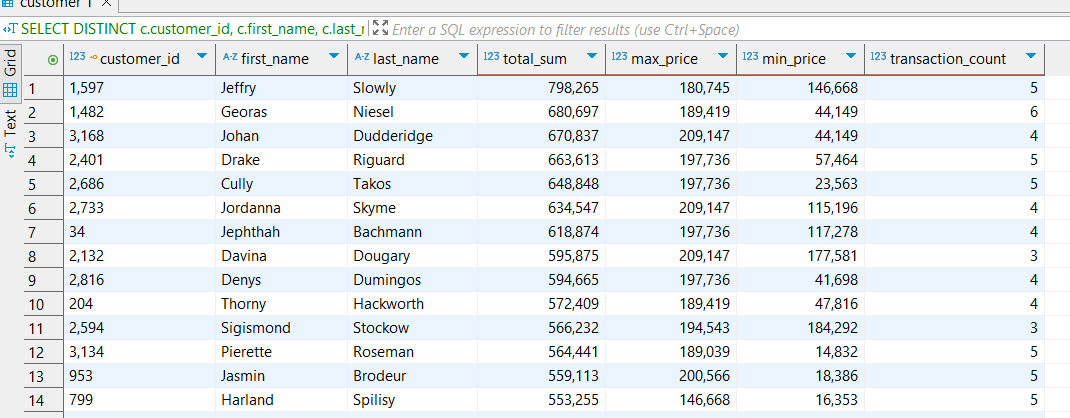

Оба способа дают одинаковый результат для этой задачи.

**5. Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы.**



```
SELECT
    c.first_name,
    c.last_name,
    SUM(t.list_price) AS total_sum
FROM customer c
JOIN transaction t ON c.customer_id = t.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING SUM(t.list_price) = (
    SELECT MIN(total_sum)
    FROM (
        SELECT SUM(t2.list_price) AS total_sum
        FROM transaction t2
        JOIN customer c2 ON t2.customer_id = c2.customer_id
        GROUP BY c2.customer_id
    ) AS subquery
);
```



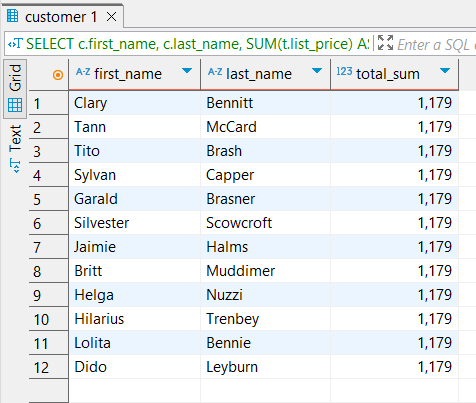



```
SELECT
    c.first_name,
    c.last_name,
    SUM(t.list_price) AS total_sum
FROM customer c
JOIN transaction t ON c.customer_id = t.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name
HAVING SUM(t.list_price) = (
    SELECT MAX(total_sum)
    FROM (
        SELECT SUM(t2.list_price) AS total_sum
        FROM transaction t2
        JOIN customer c2 ON t2.customer_id = c2.customer_id
        GROUP BY c2.customer_id
    ) AS subquery
);
```



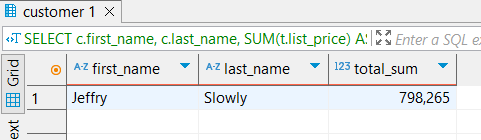

**6. Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций.**



```
WITH ranked_transactions AS (
    SELECT
        t.transaction_id,
        t.customer_id,
        t.transaction_date,
        t.list_price,
        ROW_NUMBER() OVER (
            PARTITION BY t.customer_id
            ORDER BY t.transaction_date
        ) AS rn -- Нумерация транзакций для каждого клиента
    FROM transaction t
)
SELECT
    rt.transaction_id,
    rt.customer_id,
    rt.transaction_date,
    rt.list_price
FROM ranked_transactions rt
WHERE rt.rn = 1; -- Выбираем только первые транзакции
```



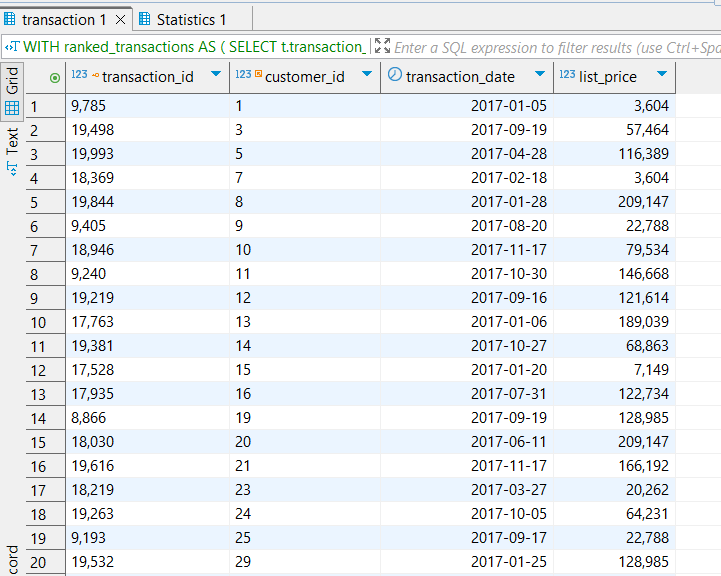

**7. Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях).**



```
WITH transaction_intervals AS (
    SELECT
        c.customer_id,
        c.first_name,
        c.last_name,
        c.job_title,
        t.transaction_date,
        LAG(t.transaction_date) OVER (
            PARTITION BY t.customer_id
            ORDER BY t.transaction_date
        ) AS prev_transaction_date,
        (t.transaction_date - LAG(t.transaction_date) OVER (
            PARTITION BY t.customer_id
            ORDER BY t.transaction_date
        )) AS interval_days
    FROM transaction t
    JOIN customer c ON t.customer_id = c.customer_id
),
max_interval AS (
    SELECT
        customer_id,
        MAX(interval_days) AS max_interval_days
    FROM transaction_intervals
    GROUP BY customer_id
)
SELECT
    ti.first_name,
    ti.last_name,
    ti.job_title,
    ti.interval_days
FROM transaction_intervals ti
JOIN max_interval mi ON ti.customer_id = mi.customer_id
    AND ti.interval_days = mi.max_interval_days
WHERE ti.interval_days IS NOT NULL
ORDER BY ti.interval_days DESC;
```



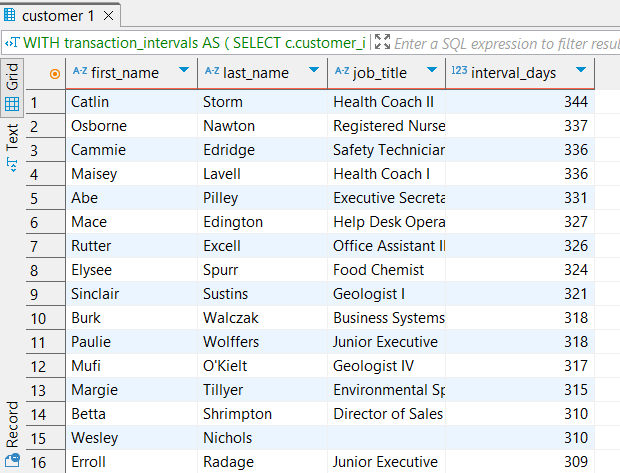